In [2]:
#import functions
%pylab inline

# from MyUnits import *
from MyFunctions import *
from qutip import *

# from MyQubit import *
# import mpld3
import multiprocessing as mp
import itertools
import datetime





Populating the interactive namespace from numpy and matplotlib


In [2]:

%%javascript
IPython.load_extensions('usability/codefolding/main');
IPython.load_extensions('toggle_all_line_number.js');

<IPython.core.display.Javascript object>

In [3]:
import scipy.constants as sc

In [4]:
import time
import datetime

## Hamiltonian derivated from Hartmann and Abdi (PRL 114 173602)

$$4 E_{C} n_{{ac}}^{2} \left({{c}^\dagger} + {c}\right)^{2} + 8 E_{C} n_{{ac}} n_{{dc}} \left({{c}^\dagger} + {c}\right) + \frac{4 i}{2^{0.25}} E_{C} n_{{ac}} \left(\frac{E_{J}}{E_{C}}\right)^{0.25} \left(- {{a}^\dagger} + {a}\right) \left({{c}^\dagger} + {c}\right) + 4 E_{C} n_{{dc}}^{2} + \frac{4 i}{2^{0.25}} E_{C} n_{{dc}} \left(\frac{E_{J}}{E_{C}}\right)^{0.25} \left(- {{a}^\dagger} + {a}\right) - \frac{E_{C} \left(\frac{E_{J}}{E_{C}}\right)^{0.5}}{2^{0.5}} \left(- {{a}^\dagger} + {a}\right)^{2} + \frac{E_{J} \left(\frac{E_{C}}{E_{J}}\right)^{0.5}}{2^{0.5}} \left({{a}^\dagger} + {a}\right)^{2} - \frac{2^{1.0} E_{J}}{24} \left(\frac{E_{C}}{E_{J}}\right)^{1.0} \left({{a}^\dagger} + {a}\right)^{4} + \left({{b}^\dagger} + {b}\right) \left(4 g_{0} n_{{ac}}^{2} \left({{c}^\dagger} + {c}\right)^{2} + 8 g_{0} n_{{ac}} n_{{dc}} \left({{c}^\dagger} + {c}\right) + \frac{4 i}{2^{0.25}} g_{0} n_{{ac}} \left(\frac{E_{J}}{E_{C}}\right)^{0.25} \left(- {{a}^\dagger} + {a}\right) \left({{c}^\dagger} + {c}\right) + 4 g_{0} n_{{dc}}^{2} + \frac{4 i}{2^{0.25}} g_{0} n_{{dc}} \left(\frac{E_{J}}{E_{C}}\right)^{0.25} \left(- {{a}^\dagger} + {a}\right) - \frac{g_{0} \left(\frac{E_{J}}{E_{C}}\right)^{0.5}}{2^{0.5}} \left(- {{a}^\dagger} + {a}\right)^{2}\right)$$

In [5]:
def Ht(t, args):
    #
    # evaluate the hamiltonian at time t. 
    #
    
    H0 = args['H0']
    c = args['c']
    cDag = args['cDag']
    A = args['A']
    
    w  = args['w']

    return H0 + A * (c + cDag)*cos(w*t) #(a * exp(1j*w*t) + aDag * exp(-1j*w*t))


In [6]:

def  calc_spectrum_5(N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w,**kwargs):
    
    w_q = sqrt(8 * Ec * Ej) - Ec
    zeta = Ej/Ec
    
    # qubit operators
    
    a = tensor(destroy(N),qeye(M),qeye(P))
    n_a = a.dag() * a
    x_a = a.dag() + a
    p_a = a - a.dag()
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(N),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(N),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(N),qeye(M),qeye(P))
    
    
    # Hamiltonian
    
    
    H1 = sqrt(8*Ec*Ej) *(a.dag()*a) - Ec/12 * (a + a.dag())**4
    
    # H1 = w_q * a.dag() * a - Ec/12 * (a.dag())**2 * a**2
    
    H2 = w_nr * (b.dag() * b)
    
    H3 = w_c  * (c.dag() * c)
    H3a = (w_c-w) * (c.dag() * c ) + A*(c.dag()+c)
    
    
    H4 = 4 * Ec * n_dc**2 * x_b**2
    
    H5 = 4 * Ec * n_ac**2 * x_c**2
    
    H6 = 4 * 1j * Ec * n_ac * (zeta/2)**(1/4) * p_a * x_c
    
    H7 = 4 * g0 * n_dc**2 * x_b**3
    
    H8 = 8 * Ec * n_dc * n_ac * x_b * x_c
    
    H9 = 4 * 1j * Ec * n_dc * (zeta/2)**(1/4) * p_a * x_b
    
    H10 = 8 * g0 * n_dc * n_ac * x_b**2 * x_c 
    
    H11 = 4 * 1j * g0 * n_dc * (zeta/2)**(1/4) * p_a * x_b**2
    
    H12 = 4 * g0 * n_ac**2 * x_c**2 * x_b 
    
    H13 = 4 * 1j * g0 * n_ac * (zeta/2)**(1/4) * p_a * x_b * x_c
    
    H14 = - g0 * sqrt(zeta/2) * p_a**2 * x_b
    
    # Time domain
    
    
    
    
    # Colapse Operators
    
    c_op_list = []
    
    kappa_n = 0.0002468 # cavity
    
    gamma_rel = 6.66e-04 # qubit
    gamma_dep = 0.0012 # qubit
    
    Gamma_m = 0.01 # MR
    
    Ta = 60e-3 #k
    Tb = 60e-3 #k
    
    n_th_a = 1/(exp(sc.h*w_q*1e9/(sc.k*Ta)-1))
    n_th_b = 1/(exp(sc.h*w_nr*1e9/(sc.k*Tb)-1))
    
    # cavity
    c_op_list = []

    rate = kappa_n * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa_n * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma_rel * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a)

    rate = gamma_rel * (n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a.dag())

    rate = gamma_dep / 2 * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a.dag()*a)
        
    rate = Gamma_m * (1 + n_th_b)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)

    rate = Gamma_m * n_th_b
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag())    
        
    
    if 'mapping' in kwargs:
               
        H0 = H1 + H2 + H3a + H4 + H5 + H6 + H8 + H9 + H7+ H10 + H11 + H12 + H13 + H14 #+ H5
        rho = steadystate(H0,c_op_list)
        rho_b = rho*b.dag()*b
        rho_a = rho*a.dag()*a
        rho_c = rho*c
        rho_d = rho*(a)
        
        return rho_c.tr(),rho_a.tr(),rho_b.tr(),rho_d.tr()
    
    if 'energies'in kwargs:
        H = H1 + H2 + H3 + H4 + H5 + H6 + H7  + H8 + H9 + H10 + H11 + H12 + H13 + H14
        
        return H.eigenenergies() #+ H4
    
    
    if 'states'in kwargs:
        H = H1 + H2 + H3 + H4 + H5 + H6 + H7  + H8 + H9 + H10 + H11 + H12 + H13 + H14
        evals, ekets = H.eigenstates(eigvals=5)
        
#         na_expect = [expect[n_a,ekets[i]] for i in range(5)]
#         nb_expect = [expect[n_b,ekets[i]] for i in range(5)]
#         nc_expect = [expect[n_c,ekets[i]] for i in range(5)]
#         c_expect = [expect[c,ekets[i]] for i in range(5)]
        return evals,ekets#na_expect,nb_expect,nc_expect,c_expect
    
    
    if 'time'in kwargs:
        
        H0 = H1 + H2 + H3 + H4 + H5 + H6 + H7  + H8 + H9 + H10 + H11 + H12 + H13 + H14 
        H_args = {'H0': H0, 'c': c, 'cDag': c.dag() , 'A' : A , 'w': w}
#         rhs_generate(Ht, c_op_list, H_args)
    #     rho = steadystate(H,c_op_list)
        opts = Options(rhs_reuse=True)
        T = 2 * pi / w

        U = propagator(Ht, T, c_op_list, H_args,opts)

        rho = propagator_steadystate(U)

        rho_b = rho*b.dag()*b
        rho_a = rho*a.dag()*a
        rho_c = rho*c
        rho_d = rho*(a)
        
        return rho_c.tr(),rho_a.tr(),rho_b.tr(),rho_d.tr()



In [7]:
def calc_spectrum_5a(N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w,**kwargs):
    
    w_q = sqrt(8 * Ec * Ej) - Ec
    zeta = Ej/Ec
    
    # qubit operators
    
    sm = tensor(destroy(2),qeye(M),qeye(P))
    sz = tensor(sigmaz(),qeye(M),qeye(P))
    sx = tensor(sigmax(),qeye(M),qeye(P))
    na = sm.dag() * sm
    x_a = sm + sm.dag()
    p_a = sm - sm.dag()
    I = tensor(qeye(2), qeye(M),qeye(P))
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(2),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(2),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(2),qeye(M),qeye(P))
    
    # Identity
    
    I = tensor(qeye(N),qeye(M),qeye(P))
    
    
    # Hamiltonian
    
    
    H1 = w_q/2 *(sz) 
    
    # H1 = w_q * a.dag() * a - Ec/12 * (a.dag())**2 * a**2
    
    H2 = w_nr * (b.dag() * b - I/2)
    
    H3 = w_c * (c.dag() * c - I/2) + A*(c.dag()+c)
    
    H4 = 4 * Ec * n_dc**2 * x_b**2
    
    H5 = 4 * Ec * n_ac**2 * x_c**2
    
    H6 = 4 * 1j * Ec * n_ac * (zeta/2)**(1/4) * p_a * x_c
    
    H7 = 4 * g0 * n_dc**2 * x_b**3
    
    H8 = 8 * Ec * n_dc * n_ac * x_b * x_c
    
    H9 = 4 * 1j * Ec * n_dc * (zeta/2)**(1/4) * p_a * x_b
    
    H10 = 8 * g0 * n_dc * n_ac * x_b**2 * x_c 
    
    H11 = 4 * 1j * g0 * n_dc * (zeta/2)**(1/4) * p_a * x_b**2
    
    H12 = 4 * g0 * n_ac**2 * x_c**2 * x_b 
    
    H13 = 4 * 1j * g0 * n_ac * (zeta/2)**(1/4) * p_a * x_b * x_c
    
    H14 = - g0 * sqrt(zeta/2) * p_a**2 * x_b
    
    c_op_list = []
    
    kappa_n = 0.0002468 # cavity
    
    gamma_rel = 6.66e-04 # qubit
    gamma_dep = 0.0012 # qubit
    
    Gamma_m = 0.001 # MR
    
    Ta = 60e-3 #k
    Tb = 60e-3 #k
    
    n_th_a = 1/(exp(sc.h*w_q*1e9/(sc.k*Ta)-1))
    n_th_b = 1/(exp(sc.h*w_nr*1e9/(sc.k*Tb)-1))
    
    # cavity
    c_op_list = []

    rate = kappa_n * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa_n * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma_rel * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    rate = gamma_rel * (n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    rate = gamma_dep / 2 * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)
        
    rate = Gamma_m * (1 + n_th_b)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)

    rate = Gamma_m * n_th_b
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag())    
        
    
    if 'mapping' in kwargs:
               
        H0 = H1 + H2 + H3 + H4 + H5 + H6 + H8 + H9 + H7+ H10 + H11 + H12 + H13 + H14 #+ H5
        rho = steadystate(H0,c_op_list)
        rho_c = rho*c
        return rho_c.tr()
    
    elif 'energies'in kwargs:
        H = H1 + H2 + H3 + H4 + H5 + H6 + H8 + H9 + H7+ H10 + H11 + H12 + H13 + H14
        
        return H.eigenenergies() #+ H4
    
    elif 'time'in kwargs:
        
        H0 = H1 + H2 + H3 
        H_args = {'H0': H0, 'c': c, 'cDag': c.dag() , 'A' : A , 'w': w}

    #     rho = steadystate(H,c_op_list)

        T = 2 * pi / w

        U = propagator(Ht, T, c_op_list, H_args)

        rho_ss = propagator_steadystate(U)

        rho_c = rho_ss*c
        
        return rho_c.tr()

    

# rhs_generate()

In [5]:
N,M,P = 4, 4 ,4

# qubit Cavity parameters
Ej_max = 16 
Ej = 4 
Ec = 0.2 
w_nr = 3.5 
w_c = 5.0  
Cg = 10e-15 
Cc = 1e-12
Cb = 50e-15
Cnr = 2e-17

# mechanical resonator

V_dc = 1

m = (700e-9)*(65e-9)*(100e-9)*2700 
Xzpm = sqrt(sc.hbar/(2*m*w_nr*2*pi*1e9))
print('X_ZPM =',Xzpm)
d0 = 30e-9 
g0 = Ec/d0 * Cnr/(Cg+Cb+Cnr)*Xzpm*1e9
print('g0 =', g0)

# Cavity effect
n_ac = Cg /2/sc.e * sqrt(sc.h*w_c*2*pi*1e9/2/Cc)
print('N_ac =',n_ac)



n_dc = Cnr/d0*V_dc/2/sc.e*Xzpm**2*1e9 + Cnr*V_dc/2/sc.e*Xzpm*1e9

print('n_dc = ',n_dc)

d = 0.1 # asymetry 

A = 0.0003# field aplitude

w = 5.001
print('E_q =', sqrt(8 * Ec * Ej_max) - Ec)

kwargs = {'energies':12}


x_i, x_f = 0.3,0.33
phi = pi * linspace(x_i,x_f,2)
Ej_vec =  Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)







X_ZPM = 1.39704864016e-14
g0 = 0.0310351802769
N_ac = 0.100681009983
n_dc =  0.000871969620119
E_q = 4.85964425627


In [12]:
ENERGY = array([calc_spectrum_5(N,M,P, x, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w,**kwargs)
                  for x in Ej_vec])

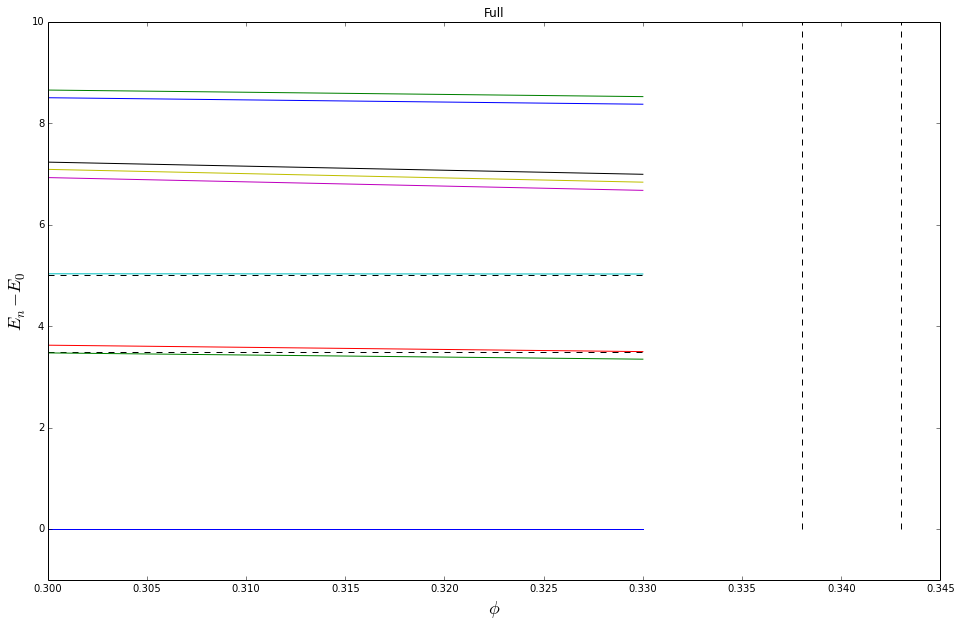

In [13]:
fig, axes = subplots(1,1, figsize=(16,10))
x_inf = -1
x_sup = 10

for n in range(len(ENERGY[0,:])):
    if n < 10:
        axes.plot(phi/pi, (ENERGY[:,n]-ENERGY[:,0]),'-')
#         axes.plot(phi/pi, (ENERGY[:,n]-ENERGY[:,0])/2,'--')

#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'$E_n-E_0$', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed') 
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
axes.vlines(0.338,0,10,linestyles='dashed')
axes.vlines(0.343,0,10,linestyles='dashed')


In [14]:
y_i,y_f = 4.99,5.01
y_vec = linspace(y_i,y_f,2) 
    
# phi = linspace(0,pi,100)

x_vec =  Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)



a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':15,'time':1}

In [15]:

# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    total_time=0
    time_1 = []
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_5,(N,
                                                 M,
                                                 P,
                                                 a1,
                                                 Ec,
                                                 w_nr,
                                                 w_c,
                                                 g0,
                                                 n_ac,
                                                 n_dc,
                                                 A ,
                                                 b1)
                                ,kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



     #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nMean time:%f"%(dif_time/task_count))
            print( "Total time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e



results = [ar.get() for ar in results]








Parallel Simulation with 15 CPUs 
[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Mean time:3265.094205
Total time:3:37:40


In [82]:
# results_2 = asarray(results)
# shape(results_2[:,0])

In [83]:

results_1 = asarray(results)
# qsave(results,name='ZeroVolts')
#qsave(results,name='TwentyVolts')
qsave(results,name='ThirtytyVolts')

tr_c = reshape(results_1[:,0],(-1,len(y_vec+1)))
tr_a = reshape(results_1[:,1],(-1,len(y_vec+1)))
tr_b = reshape(results_1[:,2],(-1,len(y_vec+1)))
tr_d = reshape(results_1[:,3],(-1,len(y_vec+1)))

In [84]:
shape(results_1)

(2500, 4)

In [85]:
# results_full_range = asarray(results)
# tr_c = reshape(results_1,(-1,len(y_vec+1)))
# results_small_range = asarray(results)
# tr_c = reshape(results_small_range,(-1,len(y_vec+1)))



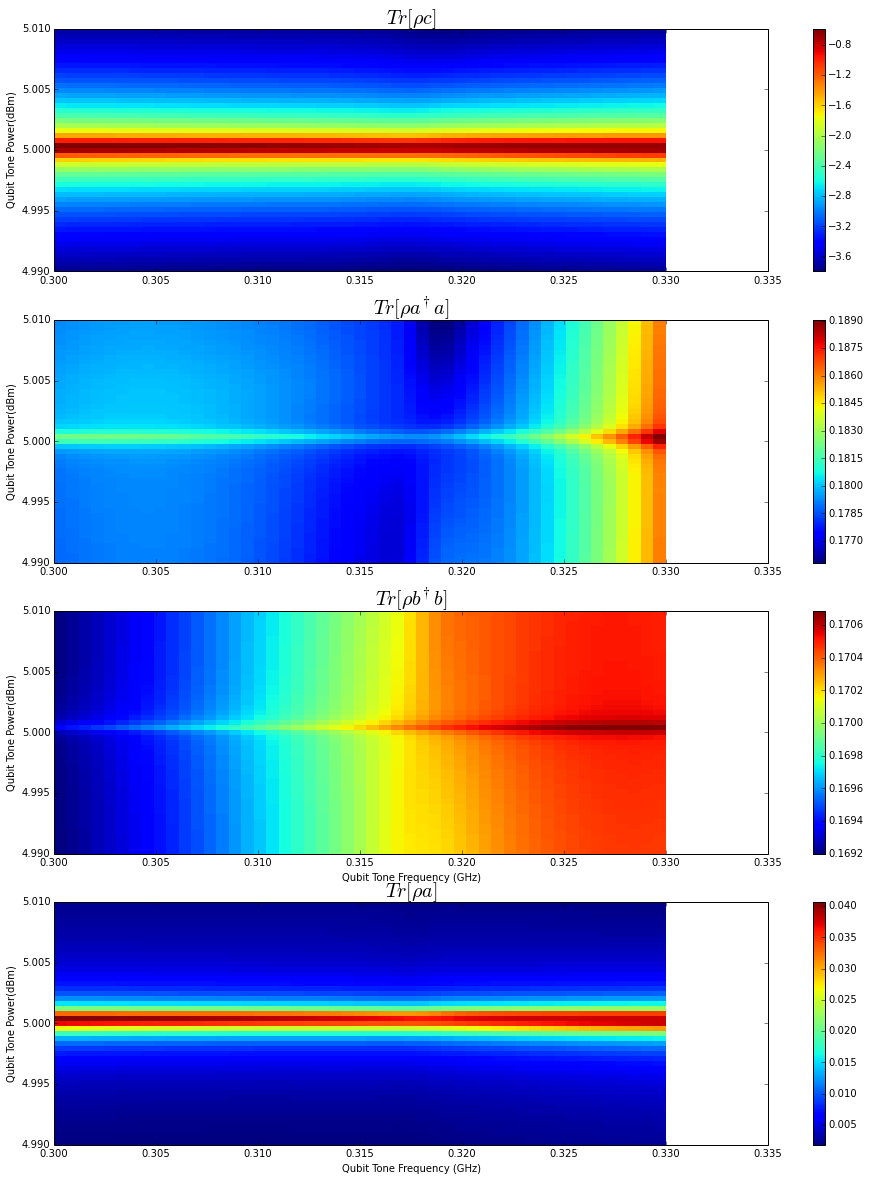

In [86]:
fig, ax = subplots(4,1, figsize=(16,20))



im = ax[0].pcolor(phi/pi,y_vec,transpose(log(abs(tr_c))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# ax[0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0].set_title(r'$Tr[\rho c]$',fontsize=20)


im = ax[1].pcolor(phi/pi,y_vec,transpose((abs(tr_a))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[1])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[1].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# ax[1].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[1].set_title(r'$Tr[\rho a^{\dagger}a]$',fontsize=20)

im = ax[2].pcolor(phi/pi,y_vec,transpose((abs(tr_b))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[2])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[2].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[2].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[2].set_title(r'$Tr[\rho b^\dagger  b]$',fontsize=20)

im = ax[3].pcolor(phi/pi,y_vec,transpose((abs(tr_d))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[3])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[3].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[3].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[3].set_title(r'$Tr[\rho a]$',fontsize=20)

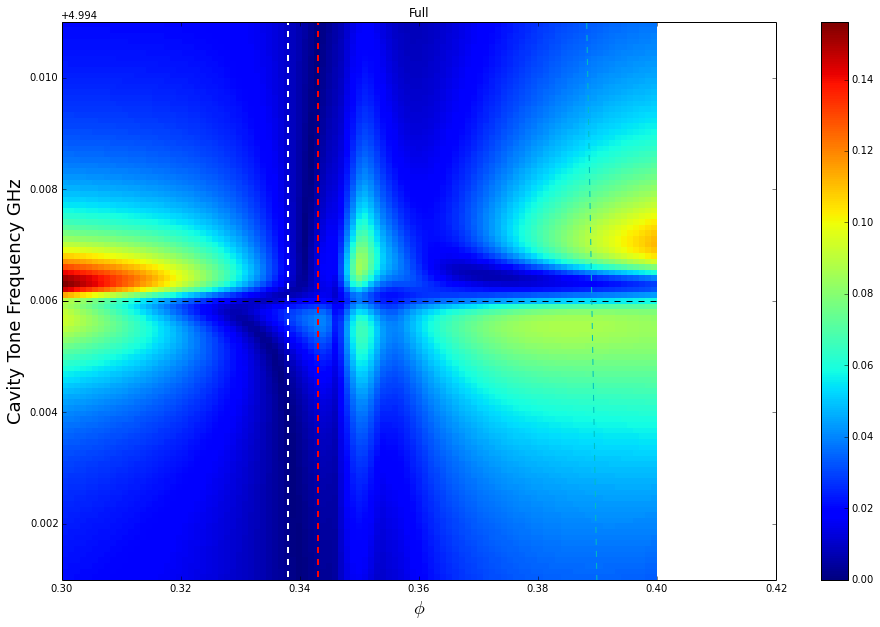

In [646]:
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(ENERGY[0,:])):
    axes.plot(phi/pi, (ENERGY[:,n]-ENERGY[:,0]),'-')
    axes.plot(phi/pi, (ENERGY[:,n]-ENERGY[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(y_inf, y_sup)
# axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
axes.vlines(0.338,0,10,linestyles='dashed',linewidth=2,color='white')
axes.vlines(0.343,0,10,linestyles='dashed',linewidth=2,color='red')

im = axes.pcolor(phi/pi,y_vec,transpose(
                                        (abs(tr_c))))#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

## Scan coupling  


In [44]:
y_i,y_f = 4.995,5.005
y_vec = linspace(y_i,y_f,10) 
phi= 0.319
Ej = Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)  
# phi = linspace(0,pi,100)
V_dc = linspace(0,30,5)
# x_vec =  Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)
x_vec = Cnr/d0*V_dc/2/sc.e*Xzpm**2*1e9 + Cnr*V_dc/2/sc.e*Xzpm*1e9


a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':15,'time':1}

In [ ]:
# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    total_time=0
    time_1 = []
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_5,(N,
                                                 M,
                                                 P,
                                                 Ej,
                                                 Ec,
                                                 w_nr,
                                                 w_c,
                                                 g0,
                                                 n_ac,
                                                 a1,
                                                 A ,
                                                 b1)
                                ,kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



     #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e



results = [ar.get() for ar in results]





Parallel Simulation with 15 CPUs 


KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/IPython/kernel/zmq/kernelbase.py", line 388, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.4/dist-packages/IPython/kernel/zmq/kernelbase.py", line 588, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.4/dist-packages/IPython/kernel/zmq/kerne

In [40]:
results_2 = asarray(results)
tr_c = reshape(results_2[:,0],(-1,len(y_vec+1)))
tr_a = reshape(results_2[:,1],(-1,len(y_vec+1)))
tr_b = reshape(results_2[:,2],(-1,len(y_vec+1)))
tr_d = reshape(results_2[:,3],(-1,len(y_vec+1)))

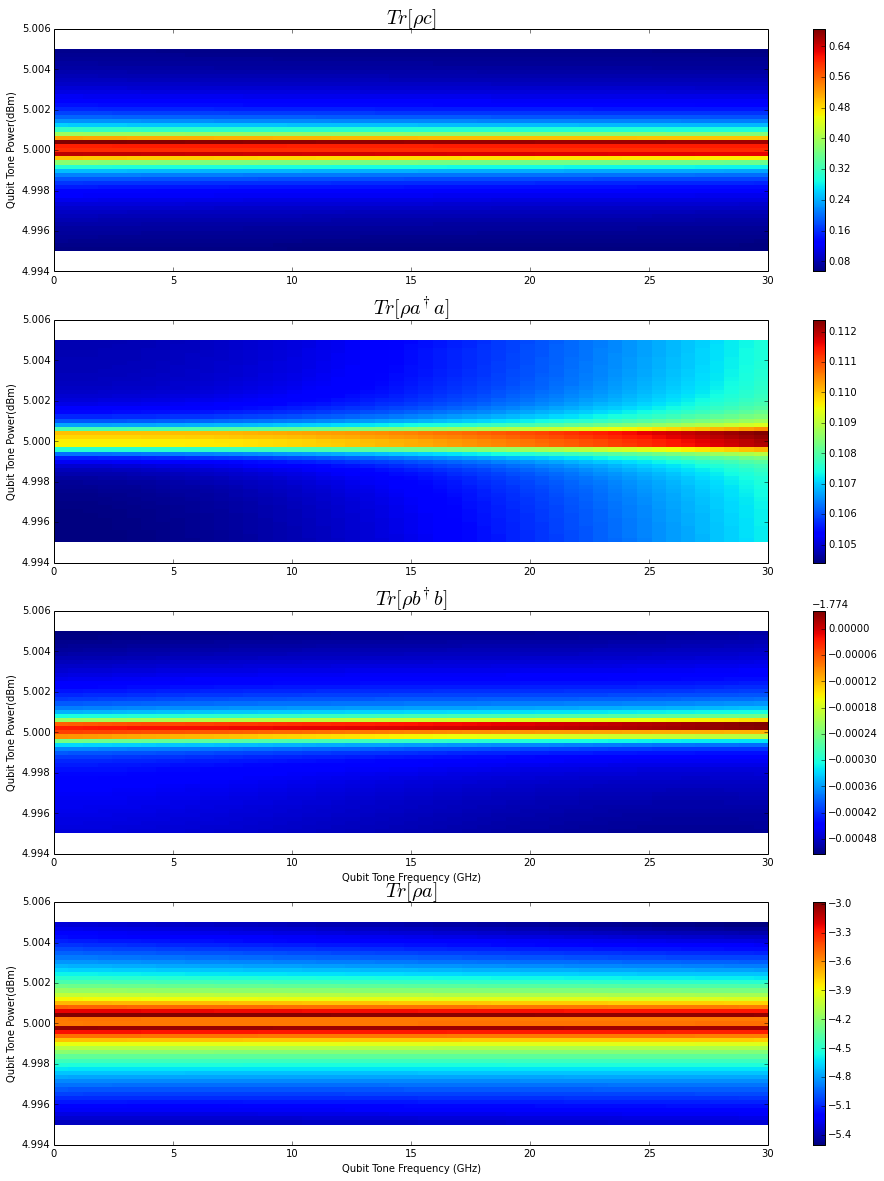

In [43]:
ig, ax = subplots(4,1, figsize=(16,20))



im = ax[0].pcolor(V_dc,y_vec,transpose((abs(tr_c))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# ax[0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0].set_title(r'$Tr[\rho c]$',fontsize=20)


im = ax[1].pcolor(V_dc,y_vec,transpose((abs(tr_a))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[1])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[1].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# ax[1].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[1].set_title(r'$Tr[\rho a^{\dagger}a]$',fontsize=20)

im = ax[2].pcolor(V_dc,y_vec,transpose(log(abs(tr_b))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[2])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[2].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[2].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[2].set_title(r'$Tr[\rho b^\dagger  b]$',fontsize=20)

im = ax[3].pcolor(V_dc,y_vec,transpose(log(abs(tr_d))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[3])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[3].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[3].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[3].set_title(r'$Tr[\rho a]$',fontsize=20)

#Standard Hamiltonian

$$
\lambda \left({{b}^\dagger} {\sigma_-} + {b} {\sigma_+} - \frac{g^{2} {{b}^\dagger} {\sigma_-}}{2 \Delta^{2}} - \frac{g^{2} {b} {\sigma_+}}{2 \Delta^{2}} - \frac{g^{2} \left({{c}^\dagger}\right)^{2}}{\Delta^{2}} {\sigma_-} {b} - \frac{g^{2} \left({c}\right)^{2}}{\Delta^{2}} {\sigma_+} {{b}^\dagger}\right) + w_{mr} {{b}^\dagger} {b} + {{c}^\dagger} {c} \left(\omega_{c} + \frac{g^{2} {\sigma_z}}{\Delta} - \frac{g^{2} \lambda}{\Delta^{2}} {{b}^\dagger} {\sigma_-} - \frac{g^{2} \lambda}{\Delta^{2}} {b} {\sigma_+}\right) + {\sigma_z} \left(\frac{w_{q}}{2} + \frac{g^{2}}{2 \Delta} + \frac{g \lambda}{\Delta} {{b}^\dagger} {c} + \frac{g \lambda}{\Delta} {{c}^\dagger} {b}\right)
$$

In [5]:
%%javascript
IPython.load_extensions('usability/codefolding/main');

IPython.load_extensions('toggle_all_line_number.js');

<IPython.core.display.Javascript object>

In [488]:
# Hamiltonians Functions
def Ht(t, args):
    #
    # evaluate the hamiltonian at time t. 
    #
    
    H0 = args['H0']
    c = args['c']
    cDag = args['cDag']
    A = args['A']
    
    w  = args['w']

    return H0 + A * (c + cDag)*cos(w*t) #(a * exp(1j*w*t) + aDag * exp(-1j*w*t))




# Calc Spectrum
def calc_spectrum_6(N,M,P, w_c,w_nr, w_q,L,g,A,w=0, **kwargs):
    
    # dispersive Qubit CPW NR 
    Delta = w_q - w_c
    delta = w_q - w_nr
    # qubit operators
    
    sm = tensor(create(2),qeye(M),qeye(P))
    sz = tensor(sigmaz(),qeye(M),qeye(P))
    sx = tensor(sigmax(),qeye(M),qeye(P))
    nq = sm.dag() * sm
    xq = sm + sm.dag()
    I = tensor(qeye(2), qeye(M),qeye(P))
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(2),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(2),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(2),qeye(M),qeye(P))
    
    
#      Hamiltonian
    if 'Full' in kwargs:
       
        H1 = (w_nr-w )* (b.dag() * b ) + L * (b.dag()*sm + b*sm.dag())

      
        H2 = (w_c - w) * (c.dag() * c )  + g * (c.dag()*sm + c*sm.dag())

        H3 = sz/2 *(w_q-w)

        H4 = A * (c.dag() + c)
        
    
    
    
    if 'Disp' in kwargs:
        
       
        H1 = w_nr * (b.dag() * b + 1/2) + L * sx *(b.dag() + b)

        H2 = (c.dag() * c ) * ( w_c + g**2/Delta*sz)
        H2a = (c.dag() * c ) * ( w_c - w + g**2/Delta*sz)

        H3 = sz *(w_q/2 + g**2/2/Delta) 

        H4 = A * (c.dag() + c)
        
        
    if 'Disp-RWA' in kwargs:
        
   
        
        H1 = w_nr * (b.dag() * b + 1/2) + L * (b.dag()*sm + b*sm.dag())

        H2 = (c.dag() * c ) * ( w_c + g**2/Delta*sz)
        H2a = (c.dag() * c ) * ( w_c - w + g**2/Delta*sz)

        H3 = sz *(w_q/2 + g**2/2/Delta) 

        H4 = A * (c.dag() + c)
    
    if '2Disp' in kwargs:
        
        H1 =  b.dag()*b *(w_nr - 2 * g * L**2 /Delta / delta *(sm*c.dag() + sm.dag() *c)) 
        - g*L**2/Delta/delta*(c.dag()*sm+c*sm.dag())
        
        H2 = c.dag()*c *(w_c + g**2/Delta * sz 
                         + (Delta + delta)*(
                         - ((g*L)/(Delta * delta))**2 
                         * ( 1 + sz + 2* b.dag()*b * sz )   
                        ))
        H2a = c.dag()*c *(w_c-w + g**2/Delta * sz 
                         + (Delta + delta)*(
                         - ((g*L)/(Delta * delta))**2 
                         * ( 1 + sz + 2* b.dag()*b * sz )   
                        ))
   
                         
        
        H3 = sz *(w_q/2 + g**2/2/Delta 
                  + b.dag()*b *(L**2/delta - (g*L/Delta/delta)**2*(delta+ Delta) ) 
                  + (L**2/2/delta - (g*L/Delta/delta)**2/2*(delta+Delta) ))
        
        H4 = A * (c.dag() + c) 
  
    
    
    
    
#     Colapse Operators
    
    c_op_list = []
    
    kappa_n = 0.0005 # cavity
    
    gamma_rel = 0.0001 # qubit
    gamma_dep = 0.002 # qubit
    
    Gamma_m = 0.01 # MR
    
    Ta = 60e-3 #k
    Tb = 60e-3 #k
    Tq = 30e-3 #K
    
    n_th_a = 1/(exp(sc.h*w_q*1e9/(sc.k*Ta)-1))
    
    n_th_q = 1/(exp(sc.h*w_q*1e9/(sc.k*Tq)-1))
    
    if Tb == 0:
         n_th_b = 0
    else:
        
        n_th_b = 1/(exp(sc.h*w_nr*1e9/(sc.k*Tb)-1))
    
    # cavity
    c_op_list = []

    rate = kappa_n * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa_n * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma_rel * (1 + n_th_q)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    rate = gamma_rel * (n_th_q)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    rate = gamma_dep / 2 * (1 + n_th_q)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)
        
    rate = Gamma_m * (1 + n_th_b)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)

    rate = Gamma_m * n_th_b
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag())    
        
    
# Solution Type    
    if 'dispersive' in kwargs:
               
        H0 = H1 + H2 + H3 + H4 #+ H5
        rho = steadystate(H0,c_op_list)
        rho_b = rho*n_b
        rho_a = rho*sz
        rho_c = rho*c
        rho_d = rho*n_c
        
        return rho_c.tr(),rho_a.tr(),rho_b.tr(),rho_d.tr()
    
    
    if 'mapping' in kwargs:
               
        H0 = H1 + H2w + H3 + H4 #+ H5
        rho = steadystate(H0,c_op_list)
        rho_c = rho*c
        return rho_c.tr()
    
    if 'energies'in kwargs:
        H = H1 + H2 + H3 + H4
        
        return H.eigenenergies() #+ H4
    
    if 'time'in kwargs:
        
        H0 = H1 + H2 + H3 #+ H4 
        H_args = {'H0': H0, 'c': c, 'cDag': c.dag() , 'A' : A , 'w': w}

    #     rho = steadystate(H,c_op_list)

        T = 2 * pi / w

        U = propagator(Ht, T, c_op_list, H_args)

        rho_ss = propagator_steadystate(U)

        
        rho_b = rho_ss*n_b
        rho_a = rho_ss*sz
        rho_c = rho_ss*c
        rho_d = rho_ss*n_c
        
        return rho_c.tr(),rho_a.tr(),rho_b.tr(),rho_d.tr()    

In [601]:
N = 2
M = 5
P = 5
w_c = 5
w_nr = 3.5
g = 0.1
L = 0.01
Ej = 15
Ec = 0.223
w = 0
w_q_max = sqrt(8 * Ec * Ej) - Ec
w_q = 3.5
print(w_q_max)
d = 0.10
A = 0.00005# field aplitude
kwargs = {'num_cpus':26,'energies':1, 'Full':1}

E = calc_spectrum_6(N,M,P, w_c,w_nr, w_q,L,g,A,w=0, **kwargs)

4.95000686255


In [602]:
E - E[0]

array([  0.        ,   3.4861658 ,   3.50719662,   5.00663759,
         6.98218488,   7.01117695,   8.48266602,   8.5107547 ,
        10.01321745,  10.47908244,  10.51427881,  11.97950711,
        12.01391305,  13.47751897,  13.51595857,  13.97645023,
        14.01691043,  15.01974106,  15.47684424,  15.51657535,
        16.97512223,  17.01835475,  17.49336153,  18.47176903,
        18.52176388,  18.97449786,  19.0189197 ,  20.02620985,
        20.47296588,  20.52051056,  21.96989761,  22.02363479,
        22.48678082,  23.49667283,  23.52953925,  23.97098889,
        24.02248412,  25.46814829,  25.52538358,  26.99391441,
        27.03229988,  27.48025638,  28.96649933,  29.02702778,
        30.49150568,  30.53471084,  32.47378684,  33.9893387 ,
        34.03687447,  37.5       ])

In [612]:
N = 2
M = 5
P = 5
w_c = 5
w_nr = 3.5
g = 0.1
L = 0.01
Ej = 15
Ec = 0.223
w = 0
w_q_max = sqrt(8 * Ec * Ej) - Ec
print(w_q_max)
d = 0.10
A = 0.00005# field aplitude

# phi = linspace(0,pi/2,200)
x_i,x_f = 0.32,0.34
phi = pi*linspace(x_i,x_f,100)
x_vec =  sqrt( 8 * Ec * Ej* abs(cos(phi))*sqrt(1+(d*tan(phi))**2) )-Ec
# energies = array([calc_spectrum_6(N,M,P, w_c,w_nr, w_q/2,L,g,A,w,**kwargs)
#                   for w_q in x_vec])
kwargs = {'num_cpus':27,'energies':1, 'Full':1}

4.95000686255


In [613]:
# Energies


# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    time_1 = []
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_6,(N,
                                                 M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 L,
                                                 g,
                                                 A,
                                                 w),kwargs
                                ,callback=None,error_callback=None) for a1 in x_vec]



    #####N,M,P, w_c,w_nr, w_q,L,g,A,w=0
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e




energies_temp = [ar.get() for ar in results]
energies = asarray(energies_temp)





Parallel Simulation with 27 CPUs 
[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Total time:0:00:01


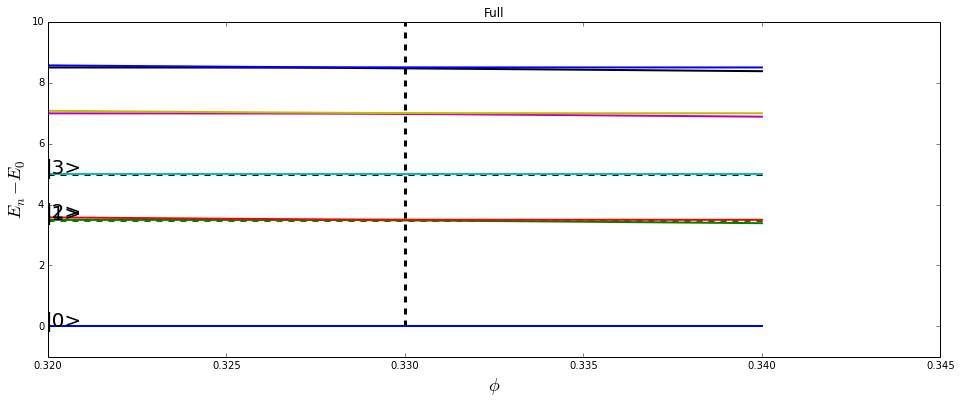

In [614]:
# Plot 
fig, axes = subplots(1,1, figsize=(16,6))
x_inf = -1
x_sup = 10

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=2)
#     axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
    if n < 4:
        axes.text(x_i,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'$E_n-E_0$', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed',linewidth=3,color='green')
axes.hlines(w_c,x_i,x_f,linestyles='dashed',linewidth=3)
axes.vlines(0.33,0,10,linestyles='dashed',linewidth=3)






In [615]:
y_i,y_f = 4.98,5.02
y_vec = linspace(y_i,y_f,100) 
a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':27,'dispersive':1, 'Full':1}

In [616]:
# Run Spectrum
# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)

# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 
t_start = time.time() # start time simulation
time_1 = []
try:
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_6,(N,
                                                 M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 L,
                                                 g,
                                                 A,
                                                 b1),kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



        #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nMean time:%f"%(dif_time/task_count))
            print( "\nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count -  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e




results = [ar.get() for ar in results]



Parallel Simulation with 27 CPUs 
[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Mean time:0.021162

Total time:0:03:31


In [617]:
# Reshape Results
#results = qload('Two_Dispersive_Simulation')
results_1 = asarray(results)
# qsave(results,name='One_Dispersive_Simulation_200x300')
#qsave(results,name='Two_Dispersive_Simulation')
# qsave(results,name='ThirtytyVolts')

tr_c = reshape(results_1[:,0],(-1,len(y_vec+1)))
tr_a = reshape(results_1[:,1],(-1,len(y_vec+1)))
tr_b = reshape(results_1[:,2],(-1,len(y_vec+1)))
tr_d = reshape(results_1[:,3],(-1,len(y_vec+1)))

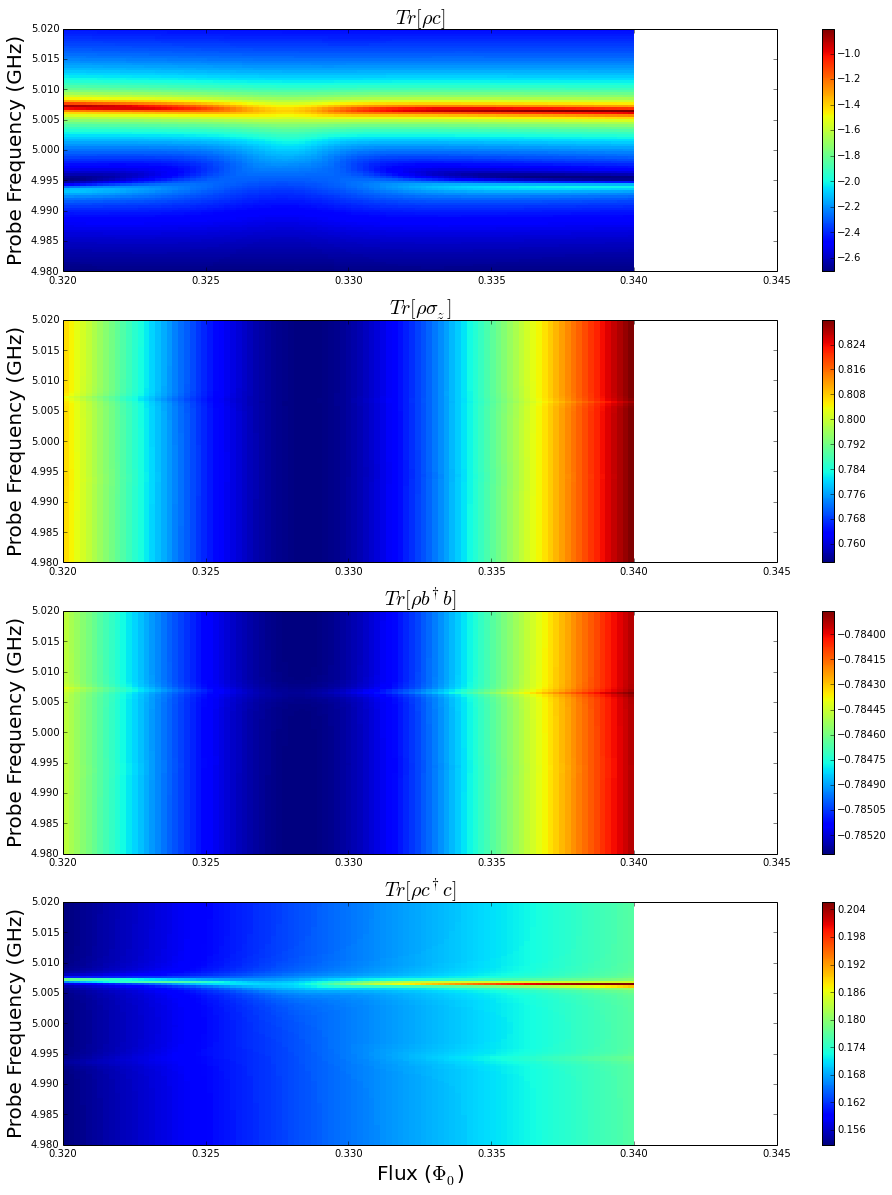

In [618]:
# Plot Graphics
fig, ax = subplots(4,1, figsize=(16,20))



im = ax[0].pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0].set_title(r'$Tr[\rho c]$',fontsize=20)


im = ax[1].pcolor(phi/pi,y_vec,transpose((abs(tr_a))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[1])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[1].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[1].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[1].set_title(r'$Tr[\rho \sigma_z]$',fontsize=20)

im = ax[2].pcolor(phi/pi,y_vec,transpose(log10(abs(tr_b))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[2])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[2].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[2].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[2].set_title(r'$Tr[\rho b^\dagger  b]$',fontsize=20)

im = ax[3].pcolor(phi/pi,y_vec,transpose((abs(tr_d))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[3])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[3].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
ax[3].set_xlabel(r'Flux ($\Phi_0$)',fontsize=20)
ax[3].set_title(r'$Tr[\rho c^\dagger c]$',fontsize=20)

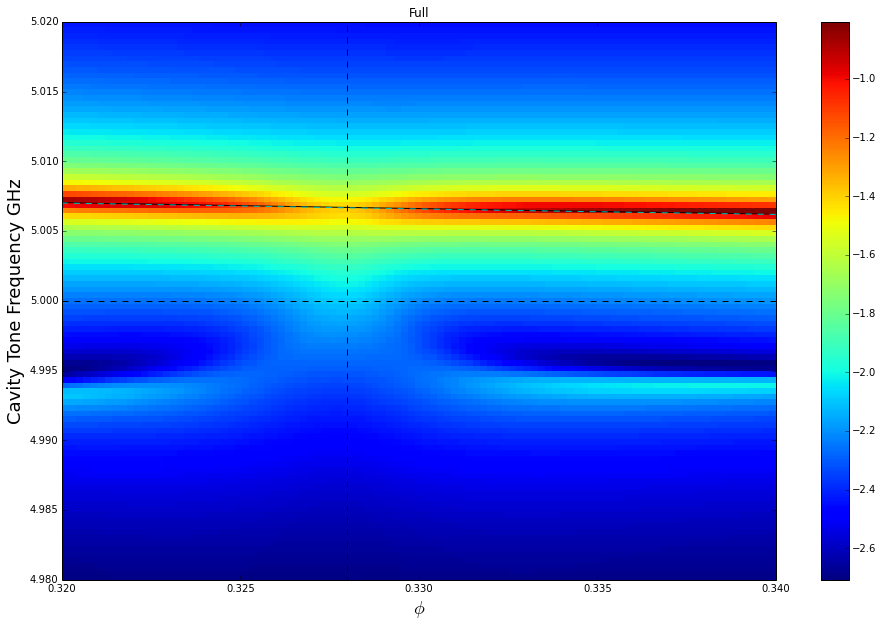

In [619]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))))#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

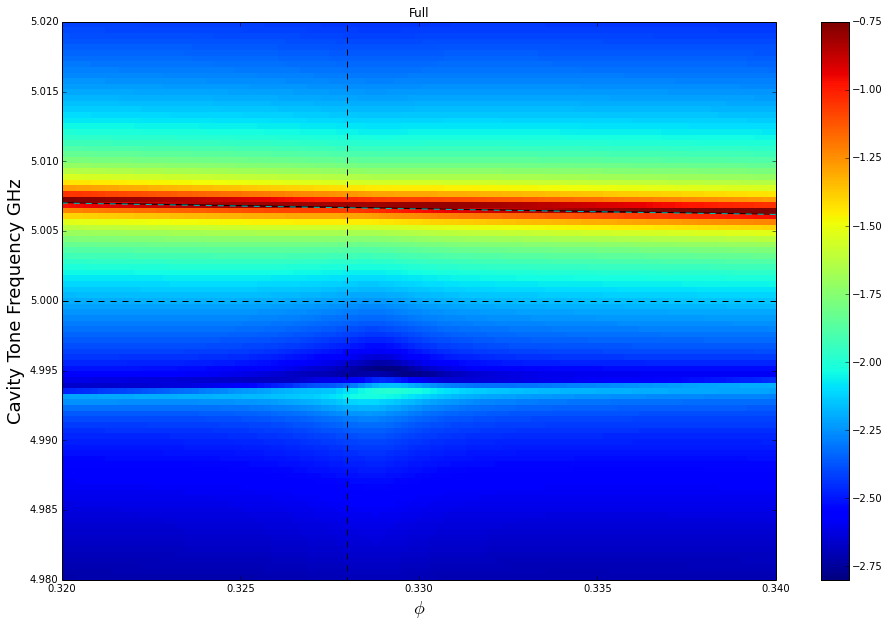

In [600]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))))#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

##Scan Coupling

In [520]:

phi = 0.328 * pi
w_q = sqrt( 8 * Ec * Ej* abs(cos(phi))*sqrt(1+(d*tan(phi))**2) )-Ec


x_i,x_f = 0.0,0.01
x_vec= linspace(x_i,x_f,100)

y_i,y_f = 4.98,5.02
y_vec = linspace(y_i,y_f,100) 

a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':27,'dispersive':1, 'Full':1}

In [521]:
# Run Spectrum
# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)

# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 
t_start = time.time() # start time simulation
time_1 = []
try:
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_6,(N,
                                                 M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 w_q,
                                                 a1,
                                                 g,
                                                 A,
                                                 b1),kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



        #####calc_spectrum_6(N,M,P, w_c,w_nr, w_q,L,g,A,w=0, **kwargs)
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nMean time:%f"%(dif_time/task_count))
            print( "\nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count -  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e




results = [ar.get() for ar in results]



Parallel Simulation with 27 CPUs 
[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Mean time:0.020642

Total time:0:03:26


In [522]:
#results = qload('Two_Dispersive_Simulation')
results_2 = asarray(results)
# qsave(results,name='One_Dispersive_Simulation_200x300')
#qsave(results,name='Two_Dispersive_Simulation')
# qsave(results,name='ThirtytyVolts')

tr_c = reshape(results_2[:,0],(-1,len(y_vec+1)))
tr_a = reshape(results_2[:,1],(-1,len(y_vec+1)))
tr_b = reshape(results_2[:,2],(-1,len(y_vec+1)))
tr_d = reshape(results_2[:,3],(-1,len(y_vec+1)))

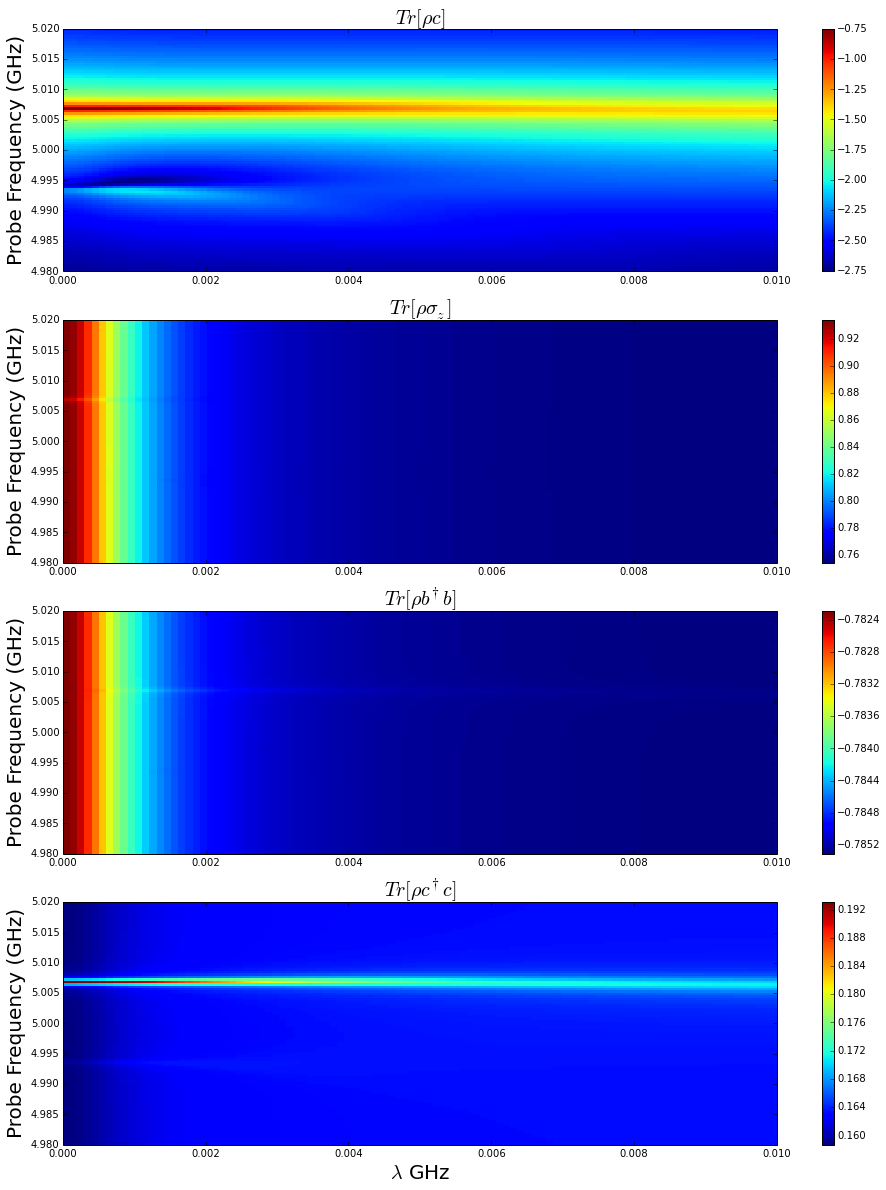

In [523]:
# Plot Graphics
fig, ax = subplots(4,1, figsize=(16,20))



im = ax[0].pcolor(x_vec,y_vec,transpose(log10(abs(tr_c))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0].set_title(r'$Tr[\rho c]$',fontsize=20)


im = ax[1].pcolor(x_vec,y_vec,transpose((abs(tr_a))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[1])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[1].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[1].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[1].set_title(r'$Tr[\rho \sigma_z]$',fontsize=20)

im = ax[2].pcolor(x_vec,y_vec,transpose(log10(abs(tr_b))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[2])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[2].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
# ax[2].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[2].set_title(r'$Tr[\rho b^\dagger  b]$',fontsize=20)

im = ax[3].pcolor(x_vec,y_vec,transpose((abs(tr_d))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[3])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[3].set_ylabel(r'Probe Frequency (GHz)',fontsize=20)
ax[3].set_xlabel(r'$\lambda$ GHz',fontsize=20)
ax[3].set_title(r'$Tr[\rho c^\dagger c]$',fontsize=20)

## Simulation New Hamiltonian 

$$
H = 
-\dfrac{E_{el}}{2}\sigma_x
-\dfrac{E_J}{2}\sigma_z
+\omega_c c^\dagger c 
+\omega_{NR} b^\dagger b
$$

In [515]:
def calc_spectrum_7(M,P, w_c,w_nr, E_j,E_c, nac, ndc, g, A, w=0, **kwargs):
    
    # dispersive Qubit CPW NR 
   
    # qubit operators
    
    sm = tensor(destroy(2),qeye(M),qeye(P))
    sz = tensor(sigmaz(),qeye(M),qeye(P))
    sx = tensor(sigmax(),qeye(M),qeye(P))
    nq = sm.dag() * sm
    xq = sm + sm.dag()
    I = tensor(qeye(2), qeye(M),qeye(P))
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(2),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(2),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(2),qeye(M),qeye(P))
    
    
    # Hamiltonian
    
    H1 = w_nr * b.dag()*b
    
    H2 = w_c * c.dag()* c
    
    H2a = (w_c-w)*c.dag()*c
    
    ng = I/2 + nac * (c.dag() + c) + ndc * (b.dag() + b)
    Ecx = E_c * (1 + g*x_b)
    
    E_el = 4*Ecx*(1-2*ng)

    
    H3 = - E_el/2 * sx 
    
    H4 = - E_j/2 * sz
    
    H5 = A*x_c
    
    # Time domain
    
    
    
    
    # Colapse Operators
    
    c_op_list = []
    
    kappa_n = 0.0002468 # cavity
    
    gamma_rel = 6.66e-04 # qubit
    gamma_dep = 0.0012 # qubit
    
    Gamma_m = 0.001 # MR
    
    Ta = 60e-3 #k
    Tb = 60e-3 #k
    
    n_th_a = 1/(exp(sc.h*E_j*1e9/(sc.k*Ta)-1))
    n_th_b = 1/(exp(sc.h*w_nr*1e9/(sc.k*Tb)-1))
    
    # cavity
    c_op_list = []

    rate = kappa_n * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa_n * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma_rel * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    rate = gamma_rel * (n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    rate = gamma_dep / 2 * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)
        
    rate = Gamma_m * (1 + n_th_b)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)

    rate = Gamma_m * n_th_b
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag())    
        
    
    
#     if 'dispersive' in kwargs:
               
#         H0 = H1 + H2b + H4 #+ H5
#         rho = steadystate(H0,c_op_list)
#         rho_c = rho*c
#         return rho_c.tr()
    
    
    if 'mapping' in kwargs:
               
        H0 = H1 + H2a + H3 + H4 + H5
        rho = steadystate(H0,c_op_list)
        rho_c = rho*c
        return rho_c.tr()
    
    elif 'energies'in kwargs:
        H = H1 + H2 + H3 + H4 #+ H3
        
        return H.eigenenergies() #+ H4
    
#     elif 'time'in kwargs:
        
#         H0 = H1 + H2 + H3 + H4 
#         H_args = {'H0': H0, 'c': c, 'cDag': c.dag() , 'A' : A , 'w': w}

#     #     rho = steadystate(H,c_op_list)

#         T = 1/ w

#         U = propagator(Ht, T, c_op_list, H_args)

#         rho_ss = propagator_steadystate(U)

#         rho_c = rho_ss*c
        
#         return rho_c.tr()

    



In [516]:
N,M,P = 2, 3 ,3

# qubit Cavity parameters
Ej_max = 16 
Ej = 4 
Ec = 0.2 
w_nr = 3.5 
w_c = 5  
Cg = 10e-15 
Cc = 1e-12
Cb = 50e-15
Cnr = 2e-17

# mechanical resonator

m = (700e-9)*(65e-9)*(100e-9)*2700 
Xzpm = sqrt(sc.hbar/(2*m*w_nr*2*pi*1e9))
print('X_ZPM =',Xzpm)
d0 = 30e-9 
g0 = Ec/d0 *Cnr/(Cg+Cb+Cnr)*Xzpm*1e9
print('g0 =', g0)

# Cavity effect
n_ac = Cg /2/sc.e * sqrt(sc.h*w_c*2*pi*1e9/2/Cc)
print('N_ac =',n_ac)

V_dc = 10

n_dc = Cnr/d0*V_dc/2/sc.e*Xzpm*100

print('n_dc = ',n_dc)

d = 0.1 # asymetry 

A = 0.0005# field aplitude

w = 5.001
print('E_q =', sqrt(8 * Ec * Ej_max) - Ec)

d = 0.1
A = 0.0003# field aplitude
kwargs = {'energies':12}

# phi = linspace(0,pi/2,200)
x_i,x_f = 0,1
phi = pi*linspace(x_i,x_f,100)
x_vec =  (sqrt(8 * Ec * Ej_max) - Ec) * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)
# energies = array([calc_spectrum_6(N,M,P, w_c,w_nr, w_q/2,L,g,A,w,**kwargs)
#                   for w_q in x_vec])

X_ZPM = 1.39704864016e-14
g0 = 0.0310351802769
N_ac = 0.100681009983
n_dc =  0.0290656404686
E_q = 4.85964425627


In [517]:
kwargs = {'num_cpus':12,'energies':1}

# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    time_1 =[]
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_7,(M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 Ec,
                                                 n_ac,
                                                 n_dc,
                                                 g,
                                                 A,
                                                 w),
                                kwargs
                                ,callback=None,error_callback=None) for a1 in x_vec]



    #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[0.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nApproximated total time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 
            
            dif_time = (time.time() - t_start)    
            if p > 0:

                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
                rem_time_1 = (datetime.timedelta(seconds=int(mean(time_1) * task_count)))
            else:
                rem_time = 0
                rem_time_1 = 0

            print("[%4.1f%%] of the simulations calculated, Estimated: Remaining: %s (Total %s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e



energies_temp = [ar.get() for ar in results]
energies = asarray(energies_temp)





Parallel Simulation with 12 CPUs 
[0.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Approximated total time:0:00:02


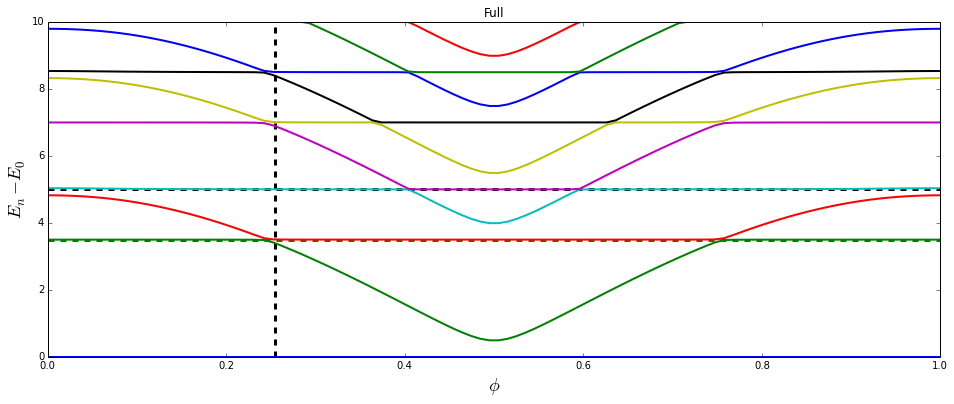

In [518]:
fig, axes = subplots(1,1, figsize=(16,6))
x_inf = 0
x_sup = 10

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=2)
#     axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'$E_n-E_0$', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed',linewidth=3,color='green')
axes.hlines(w_c,x_i,x_f,linestyles='dashed',linewidth=3)
axes.vlines(0.255,0,10,linestyles='dashed',linewidth=3)





In [519]:
y_i,y_f = 4.7,5.3
y_vec = linspace(y_i,y_f,100) 
    
# phi = linspace(0,pi/2,100)

# x_vec =  w_q_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)



# a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':12,'mapping':1}

In [520]:
# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_7,(M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 n_ac,
                                                 n_dc,
                                                 g,
                                                 A,
                                                 b1),kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



    #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[0.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nApproximated total time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 
            
            dif_time = (time.time() - t_start)    
            if p > 0:

                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
                rem_time_1 = (datetime.timedelta(seconds=int(mean(time_1) * task_count)))
            else:
                rem_time = 0
                rem_time_1 = 0

            print("[%4.1f%%] of the simulations calculated, Estimated Remaining: %s (Total %s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e



results = [ar.get() for ar in results]




Parallel Simulation with 12 CPUs 
[0.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Approximated total time:0:08:36


In [521]:
tr = reshape(results,(-1,len(y_vec+1)))
shape(tr)

(100, 100)

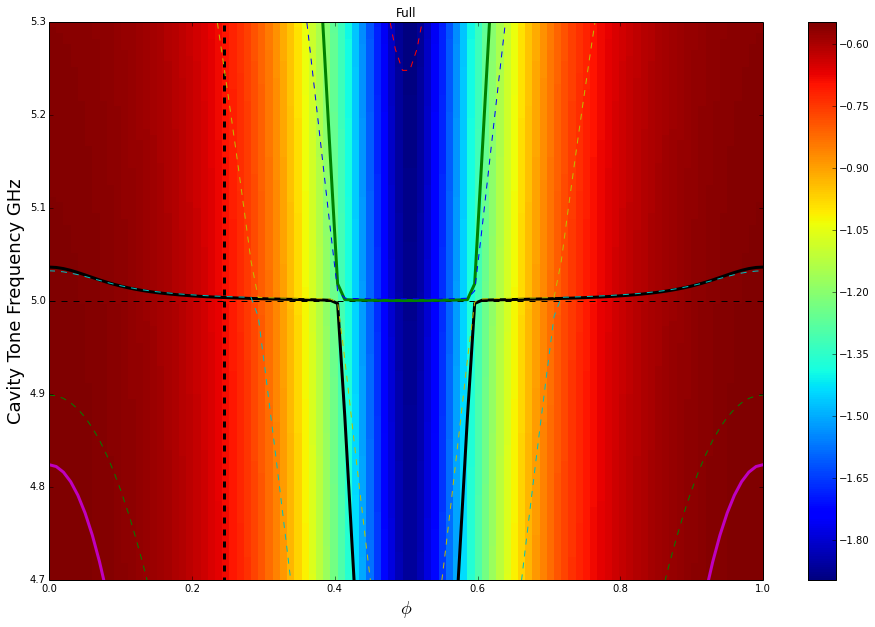

In [522]:
fig, axes = subplots(1,1, figsize=(16,10))


for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=3)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(y_i, y_f)
axes.set_xlim(x_i,x_f)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
# axes.vlines(0.24,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log(abs(tr))))#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)